# Danucore - Recruitment Exercise

In this Jupyter notebook, we present a brief exercise related to our work at Danucore. This comprises two questions: the first involves analysis of PV data; and the second involves use of a publicly-available large language model of your choice.

These exercises should take a couple of hours at most, and we would like you to use this exercise to demonstrate your thinking around the problem.

## Q1 - Predicting PV Output

The accompanying CSV file contains daily PV output data and weather data collected from a single location, covering a period of 50 months. You may assume that this data has been collected using sensors installed at the location. The variables included in the data are as follows:

 - `precip`: daily aggregate liquid precipitation;
 - `cloud cover`: percentage of the visible sky that is covered by cloud;
 - `solar radiation`: solar radiation power (in W/m$^2$);
 - `humidity`: relative humidity (expressed as a percentage);
 - `pressure`: sea level atmospheric pressure (in millibars);
 - `UV index`: an indicator for the level of daily UV exposure, based on the amount of short-wave solar radiation and dependent on the cloud cover, type of cloud, altitude and time of year; 0 represents no exposure, 10 represents a high level of exposure;
 - `temp min`: minimum daily temperature
 - `temp max`: maximum daily temperature
 - `solar energy`: daily aggregate energy from the sun (in MJ/m$^2$)

- `PV output`: daily aggregate energy output (in kWh) from a PV array with maximum capacity of 1 kWp
     
Suppose we wish to use the first nine variables (or some subset of these) to predict the daily aggregate solar energy output given by the tenth variable. Suggest and implement a method for doing this: use the first two years of data for any model fitting, and use the final two months to illustrate your model's predictive ability.

If you are using ML methods, these do not need to be fully optimised, though you should demonstrate best practice in any model fitting procedures you implement. All implementation should be carried out in Python and within this notebook.



In [3]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

Importing plotly failed. Interactive plots will not work.


In [4]:
data = pd.read_csv("solarPower_50m.csv")

In [5]:
data.columns

Index(['Unnamed: 0', 'precip', 'cloud cover', 'solar radiation', 'humidity',
       'pressure', 'UV index', 'temp min', 'temp max', 'solar energy',
       'PV output'],
      dtype='object')

In [6]:
data = data.rename(columns={'Unnamed: 0': 'ds', 'PV output':'y'})

In [7]:
data.head(10)

,ds,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,y
0,2019-12-01,0.000,72.0,27.9,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,2019-12-02,0.120,41.2,NaN,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,2019-12-03,0.000,59.8,42.5,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,2019-12-04,0.096,26.2,43.8,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,2019-12-05,0.134,85.2,26.5,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
5,2019-12-06,3.340,87.4,19.2,90.7,1008.3,1.0,8.3,11.2,1.7,0.492
6,2019-12-07,0.219,86.7,28.5,89.5,1013.2,1.0,6.9,9.8,2.2,0.776
7,2019-12-08,3.489,67.8,28.4,83.6,1001.2,2.0,5.7,10.8,2.5,0.670
8,2019-12-09,8.222,44.1,32.5,76.6,1013.7,2.0,2.5,8.6,2.9,0.944
9,2019-12-10,6.661,80.7,11.3,90.7,1013.0,1.0,2.4,11.5,1.0,0.078


In [8]:
data.tail(10)

,ds,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,y
783,2022-01-22,0.000,97.6,21.7,83.4,1038.7,1.0,2.6,5.0,1.8,1.002
784,2022-01-23,0.000,100.0,19.3,86.3,1034.9,1.0,2.2,4.1,1.5,0.944
785,2022-01-24,0.000,100.0,9.2,89.0,1032.5,0.0,3.5,4.3,0.7,0.795
786,2022-01-25,0.000,99.9,16.2,90.1,1034.4,1.0,2.5,3.6,1.5,0.687
787,2022-01-26,0.000,87.9,32.6,86.7,1034.0,2.0,0.8,7.7,3.0,1.321
788,2022-01-27,0.605,64.0,23.6,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,2022-01-28,0.191,61.8,40.8,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,2022-01-29,1.226,77.8,31.0,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,2022-01-30,0.124,38.8,53.9,88.9,1031.4,3.0,0.4,8.0,4.7,1.313
792,2022-01-31,0.773,73.0,35.6,79.0,1027.6,2.0,5.5,7.3,3.1,1.491


In [9]:
data.shape

(793, 11)

### 793 records means 793 days. 26 months data is present

In [10]:
data.dtypes

ds                  object
precip             float64
cloud cover        float64
solar radiation    float64
humidity           float64
pressure           float64
UV index           float64
temp min           float64
temp max           float64
solar energy       float64
y                  float64
dtype: object

In [11]:
data.isnull().sum()

ds                  0
precip              0
cloud cover         0
solar radiation    33
humidity            0
pressure            1
UV index            0
temp min            0
temp max            0
solar energy        0
y                   0
dtype: int64

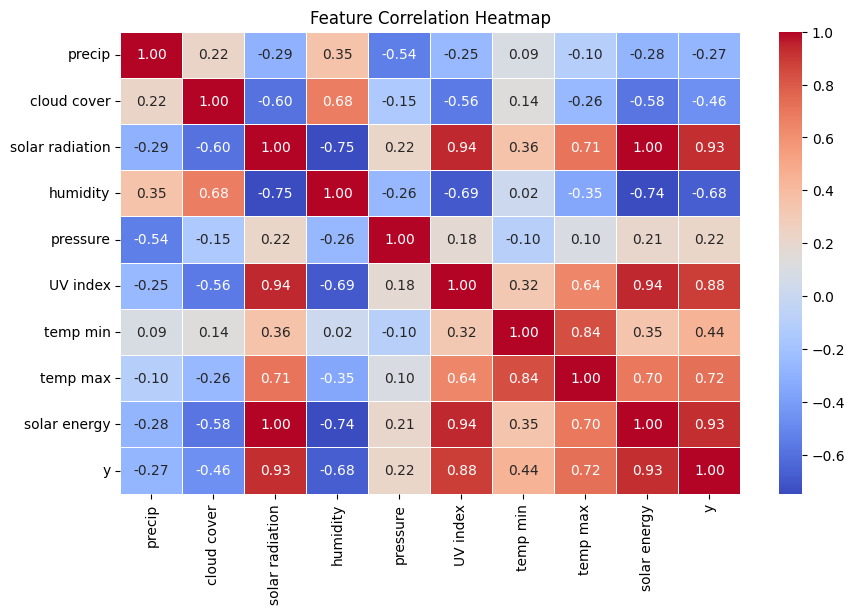

In [12]:
corr_matrix = data.drop(['ds'],axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)  
data[['solar radiation']] = imputer.fit_transform(data[['solar radiation', 'humidity', 'UV index', 'solar energy']])[:, 0:1]

In [14]:
data.loc[:, 'pressure'] = data['pressure'].ffill()


In [15]:
data.isnull().sum()

ds                 0
precip             0
cloud cover        0
solar radiation    0
humidity           0
pressure           0
UV index           0
temp min           0
temp max           0
solar energy       0
y                  0
dtype: int64

In [16]:
data.describe()

,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,y
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,2.652846,66.108701,107.409508,83.719420,1015.703405,4.050441,7.019546,13.164817,9.262169,2.804861
std,4.604500,20.495106,83.851250,9.526572,11.451926,2.471040,4.598832,5.340954,7.247400,2.044960
min,0.000000,0.000000,7.200000,47.700000,975.100000,0.000000,-3.900000,-0.100000,0.700000,0.078000
25%,0.024000,53.400000,32.800000,78.500000,1008.300000,2.000000,3.400000,9.400000,2.800000,0.855000
50%,0.506000,68.200000,86.400000,85.400000,1016.800000,4.000000,7.200000,12.200000,7.400000,2.462000
75%,3.340000,82.200000,162.600000,91.000000,1023.700000,6.000000,10.700000,17.300000,14.100000,4.566000
max,36.276000,100.000000,319.700000,98.900000,1048.400000,10.000000,18.300000,29.700000,27.700000,6.873000


In [17]:
data.columns

Index(['ds', 'precip', 'cloud cover', 'solar radiation', 'humidity',
       'pressure', 'UV index', 'temp min', 'temp max', 'solar energy', 'y'],
      dtype='object')

## Base Model With Prophet

In [18]:
train_df = data[data["ds"] < "2021-12-01"]
test_df = data[data["ds"] >= "2021-12-01"]

In [19]:
model = Prophet()

for col in ['precip', 'cloud cover', 'solar radiation', 'humidity',
       'pressure', 'UV index', 'temp min', 'temp max', 'solar energy']:
    model.add_regressor(col)

model.fit(train_df)

01:43:19 - cmdstanpy - INFO - Chain [1] start processing
01:43:20 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = test_df.drop(['y'], axis=1)
forecast = model.predict(future)


In [23]:
forecast.head(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,UV index,UV index_lower,UV index_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-01,3.099108,0.042672,1.360692,3.099108,3.099108,-0.025960,-0.025960,-0.025960,-2.370768,...,-0.014186,-0.014186,-0.014186,-1.369914,-1.369914,-1.369914,0.0,0.0,0.0,0.728340
1,2021-12-02,3.099716,0.379288,1.718524,3.099716,3.099716,-0.025960,-0.025960,-0.025960,-2.068309,...,-0.017314,-0.017314,-0.017314,-1.362575,-1.362575,-1.362575,0.0,0.0,0.0,1.031406
2,2021-12-03,3.100323,-0.369510,0.975896,3.100323,3.100323,-0.037398,-0.037398,-0.037398,-2.829652,...,0.041561,0.041561,0.041561,-1.352733,-1.352733,-1.352733,0.0,0.0,0.0,0.270671
3,2021-12-04,3.100931,0.228723,1.599455,3.100931,3.100931,-0.025960,-0.025960,-0.025960,-2.200994,...,0.073558,0.073558,0.073558,-1.340694,-1.340694,-1.340694,0.0,0.0,0.0,0.899937
4,2021-12-05,3.101539,0.420305,1.751020,3.101539,3.101539,-0.014521,-0.014521,-0.014521,-2.020689,...,-0.044644,-0.044644,-0.044644,-1.326814,-1.326814,-1.326814,0.0,0.0,0.0,1.080850
5,2021-12-06,3.102146,-0.143992,1.235298,3.102144,3.102146,-0.037398,-0.037398,-0.037398,-2.536558,...,-0.050654,-0.050654,-0.050654,-1.311488,-1.311488,-1.311488,0.0,0.0,0.0,0.565588
6,2021-12-07,3.102754,-0.247977,1.092377,3.102743,3.102754,-0.037398,-0.037398,-0.037398,-2.645286,...,0.011677,0.011677,0.011677,-1.295144,-1.295144,-1.295144,0.0,0.0,0.0,0.457468
7,2021-12-08,3.103361,0.277289,1.610326,3.103343,3.103363,-0.025960,-0.025960,-0.025960,-2.143857,...,-0.014186,-0.014186,-0.014186,-1.278231,-1.278231,-1.278231,0.0,0.0,0.0,0.959504
8,2021-12-09,3.103969,-0.040392,1.312299,3.103943,3.103979,-0.037398,-0.037398,-0.037398,-2.445295,...,-0.017314,-0.017314,-0.017314,-1.261210,-1.261210,-1.261210,0.0,0.0,0.0,0.658674
9,2021-12-10,3.104577,0.468308,1.806260,3.104534,3.104601,-0.025960,-0.025960,-0.025960,-2.002337,...,0.041561,0.041561,0.041561,-1.244544,-1.244544,-1.244544,0.0,0.0,0.0,1.102239


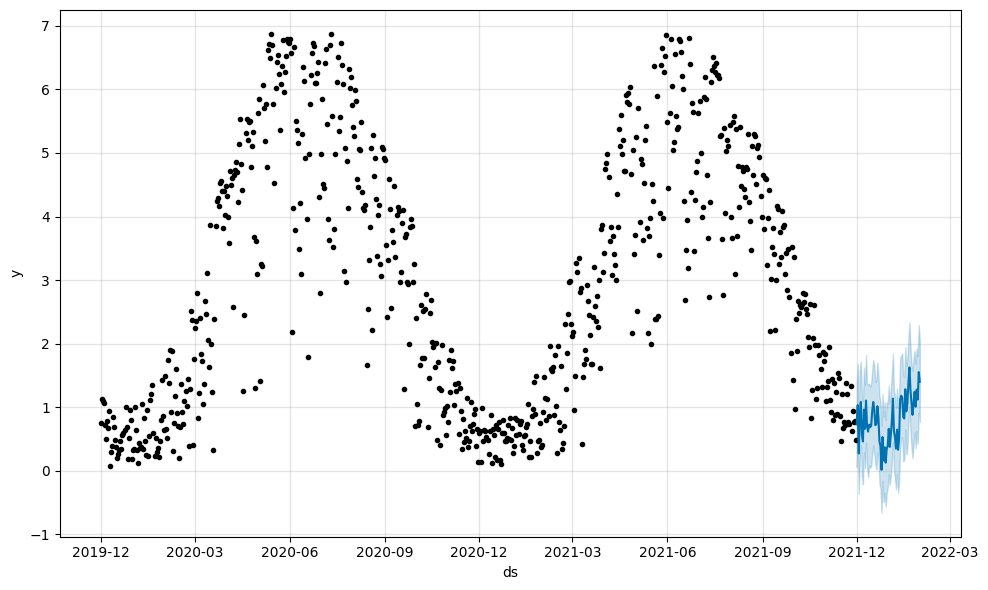

In [19]:
import matplotlib.pyplot as plt

model.plot(forecast)
plt.show()

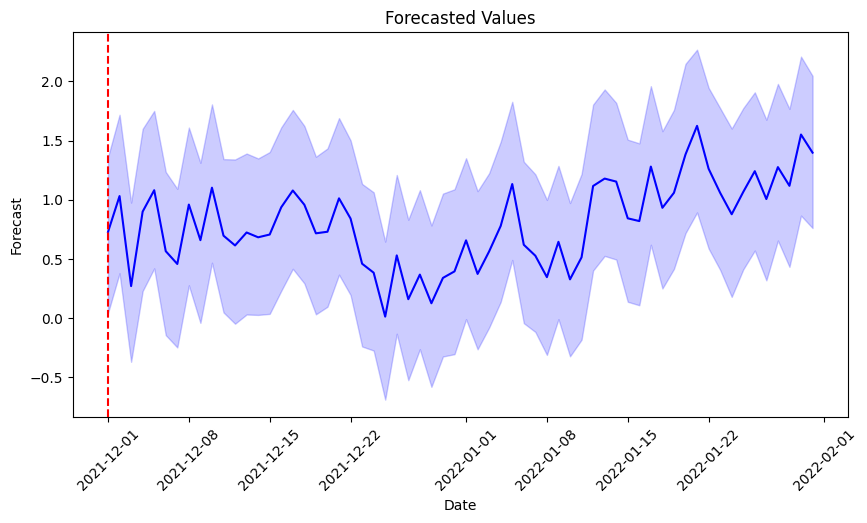

In [30]:
import matplotlib.pyplot as plt

forecast['ds'] = pd.to_datetime(forecast['ds'])
df_forecast = forecast[(forecast['ds'] > '2021-09')]
plt.figure(figsize=(10,5))
plt.plot(df_forecast['ds'], df_forecast['yhat'], color='blue')
plt.fill_between(df_forecast['ds'], df_forecast['yhat_lower'], df_forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')
plt.axvline(x=pd.Timestamp('2021-12-01'), color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast')
plt.title('Forecasted Values')
plt.xticks(rotation=45) 
plt.show()

In [31]:

# Display forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2021-12-01  0.728340    0.042672    1.360692
1 2021-12-02  1.031406    0.379288    1.718524
2 2021-12-03  0.270671   -0.369510    0.975896
3 2021-12-04  0.899937    0.228723    1.599455
4 2021-12-05  1.080850    0.420305    1.751020


In [32]:
y_true = test_df["y"].values  
y_pred = forecast["yhat"].values 

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE Score: {mae}")

MAE Score: 0.2039026566372445


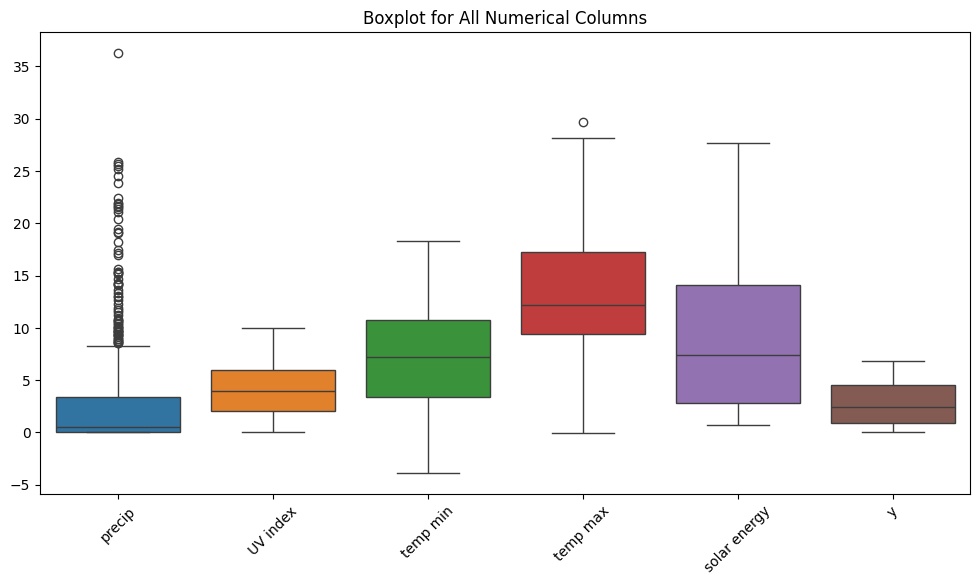

In [29]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=data.drop(['pressure','cloud cover','humidity', 'solar radiation'], axis=1))

plt.xticks(rotation=45) 
plt.title("Boxplot for All Numerical Columns")
plt.show()

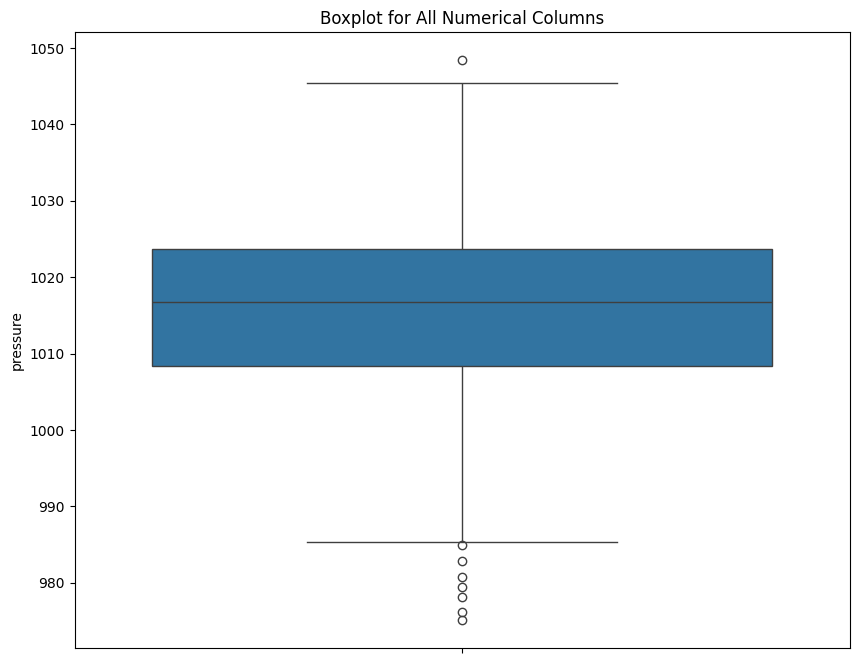

In [27]:
plt.figure(figsize=(10, 8))

sns.boxplot(data=data['pressure'])

plt.xticks(rotation=45) 
plt.title("Boxplot for All Numerical Columns")
plt.show()

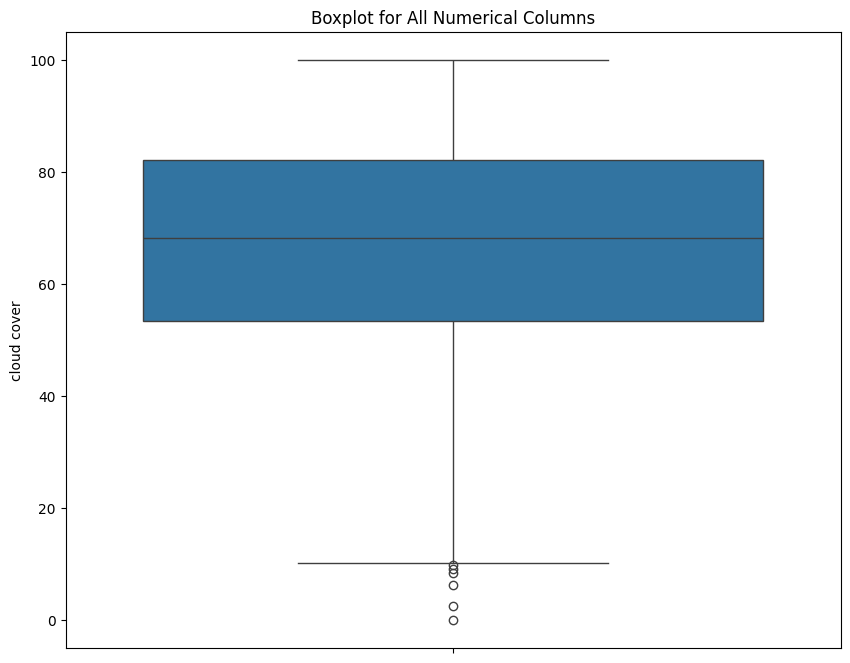

In [30]:
plt.figure(figsize=(10, 8))

sns.boxplot(data=data['cloud cover'])

plt.xticks(rotation=45) 
plt.title("Boxplot for All Numerical Columns")
plt.show()

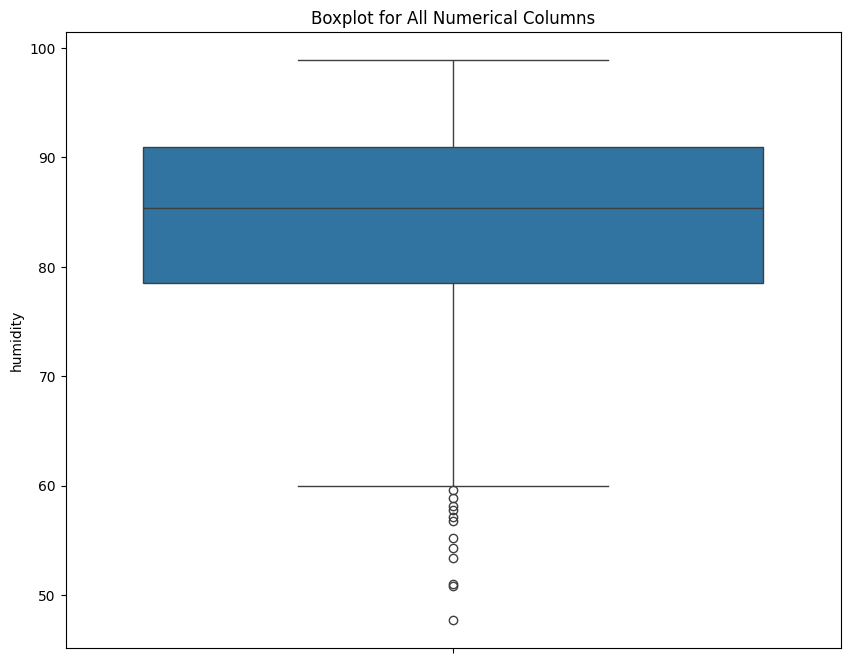

In [31]:
plt.figure(figsize=(10, 8))

sns.boxplot(data=data['humidity'])

plt.xticks(rotation=45) 
plt.title("Boxplot for All Numerical Columns")
plt.show()

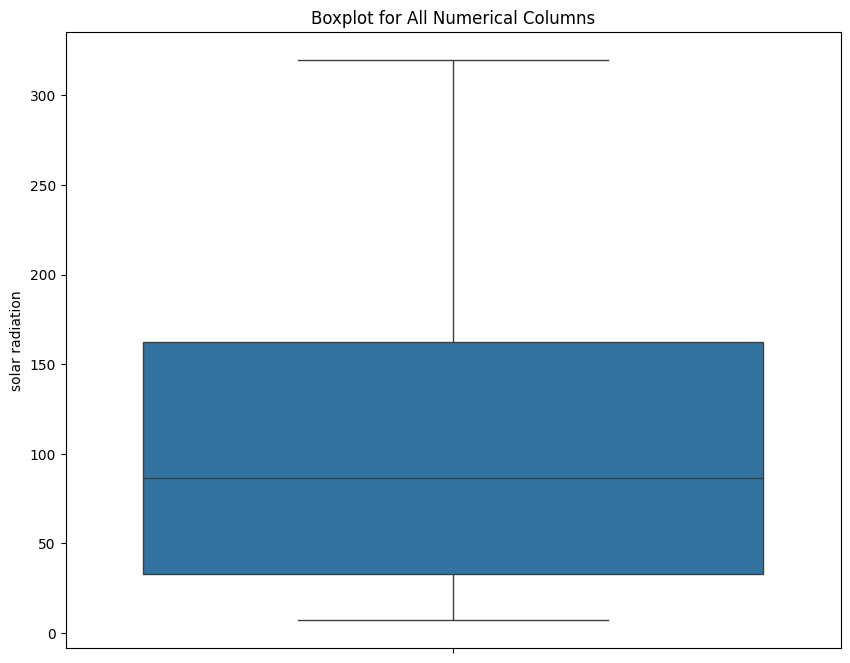

In [32]:
plt.figure(figsize=(10, 8))

sns.boxplot(data=data['solar radiation'])

plt.xticks(rotation=45) 
plt.title("Boxplot for All Numerical Columns")
plt.show()

### Model With selected features 

In [34]:
data['temp_range'] = data['temp max'] - data['temp min']

In [35]:
train_df = data[data["ds"] < "2021-12-01"]
test_df = data[data["ds"] >= "2021-12-01"]

In [36]:
model = Prophet()

for col in ['solar radiation', 'UV index', 'solar energy']:
    model.add_regressor(col)

model.fit(train_df)

01:55:20 - cmdstanpy - INFO - Chain [1] start processing
01:55:20 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future = test_df[['ds', 'solar radiation', 'UV index', 'solar energy']]
forecast = model.predict(future)


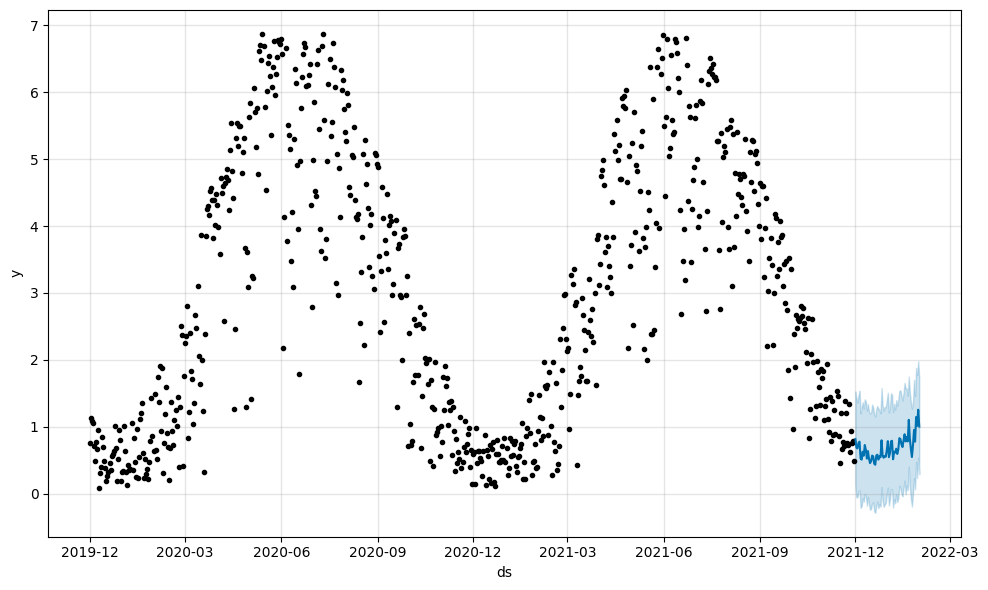

In [38]:
import matplotlib.pyplot as plt

model.plot(forecast)
plt.show()

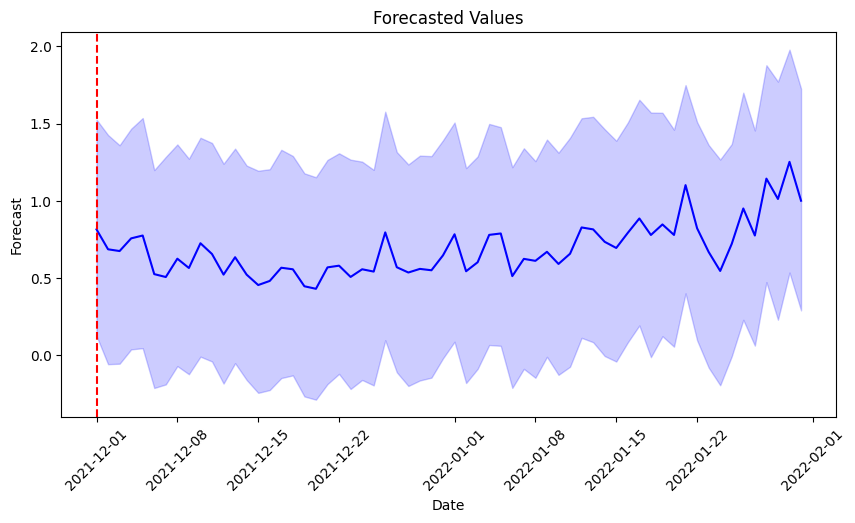

In [39]:
import matplotlib.pyplot as plt

forecast['ds'] = pd.to_datetime(forecast['ds'])
df_forecast = forecast[(forecast['ds'] > '2021-09')]
plt.figure(figsize=(10,5))
plt.plot(df_forecast['ds'], df_forecast['yhat'], color='blue')
plt.fill_between(df_forecast['ds'], df_forecast['yhat_lower'], df_forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')
plt.axvline(x=pd.Timestamp('2021-12-01'), color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast')
plt.title('Forecasted Values')
plt.xticks(rotation=45) 
plt.show()

In [40]:
y_true = test_df["y"].values  
y_pred = forecast["yhat"].values 

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE Score: {mae}")

MAE Score: 0.23466213839407404


### Regression

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [78]:
X_train = train_df.drop(['ds','y'], axis=1) 
y_train = train_df['y']

X_test = test_df.drop(['ds','y'], axis=1) 
y_test = test_df['y']

In [80]:
model = LinearRegression()
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

In [83]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.33
Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.43
R-squared (R²): -0.42


## Q2 - Extracting data using LLMs

The accompanying PDF file is a data sheet that gives specifications for a number of hardware products available from GivEnergy. Use an open source Large Language Model of your choice to run inference optimally on a single or multi-node cluster to extract the data from this pdf to the best of its ability. Please provide a record of the prompts you use in your interaction with the LLM.



In [41]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from typing import List
import os
import sqlite3
from datetime import datetime
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_groq import ChatGroq
from langchain_core.documents import Document
import time
from fastapi import FastAPI
import uvicorn
from pydantic import BaseModel, Field
from enum import Enum
import uuid
import logging
from langchain.callbacks.tracers import LangChainTracer
import subprocess
import threading

### SQL DB connection

In [42]:
DB_NAME = 'danucore.db'
def get_db_connection():
    conn = sqlite3.connect(DB_NAME)
    conn.row_factory = sqlite3.Row
    return conn

In [43]:
# function for creation of log table
def create_application():
    conn = get_db_connection()
    conn.execute('''CREATE TABLE IF NOT EXISTS application_logs
                    (id INTEGER PRIMARY KEY AUTOINCREMENT,
                     session_id TEXT,
                     user_query TEXT,
                     LLM_response TEXT,
                     model TEXT,
                     created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP)''')
    conn.close()

In [44]:
# function to insert into log table
def ins_application_log(session_id,user_query,llm_response,model):
    conn = get_db_connection()
    conn.execute('INSERT INTO application_logs (session_id, user_query, LLM_response, model) VALUES (?, ?, ?, ?)',
                 (session_id, user_query, llm_response, model))
    conn.commit()
    conn.close()

In [45]:
# fetching the history for particular session
def get_chat_history(session_id):
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('SELECT user_query, LLM_response FROM application_logs WHERE session_id = ? ORDER BY created_at', (session_id,))
    messages = []
    for row in cursor.fetchall():
        messages.extend([
            {"role": "human", "content": row['user_query']},
            {"role": "ai", "content": row['LLM_response']}
        ])
    conn.close()
    return messages

In [46]:
# fetching latest logs to display
def get_all_logs():
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('SELECT user_query, LLM_response,session_id,id,created_at FROM application_logs  ORDER BY created_at desc LIMIT 9')
    messages = []
    rows = cursor.fetchall()
    conn.close()
    for row in rows:
        messages.extend([
            {"user_query": row['user_query'], "id": str(row['id']),'LLM_response':row['LLM_response'],'created_at':row['created_at'],'session_id':row['session_id']}
        ])
    return messages

In [47]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300, length_function=len)
embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(persist_directory="./chroma_db", embedding_function=embedding_model)

C:\Users\tharu\AppData\Local\Temp\ipykernel_31684\264512334.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


In [48]:
def splits(Documents,file_name):
    splits= text_splitter.split_documents(Documents)
    for split in splits:
        split.metadata['file_name'] = file_name

    return splits

In [ ]:
output_parser = StrOutputParser()

In [49]:
# function to load docs from a folder and add to vector DB
def load_documents(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        Documents = splits(loader.load(),filename)
        print(f'no of documents = {len(Documents)}')
        vectorstore.add_documents(Documents)

        return True

In [50]:
# retriever from vector DB
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
output_parser = StrOutputParser()

In [51]:
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

In [52]:
contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

In [53]:
qa_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant. Use the following context to answer the user's question."),
    ("system", "Context: {context}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}")
])

In [54]:

def get_rag_chain(model="llama3-8b-8192"):

    llm = ChatGroq(model=model)
    history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)
    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain) 
    rag_chain = rag_chain    
    return rag_chain

In [55]:
#variables for langsmith, groq and logging file
logging.basicConfig(filename='app.log', level=logging.INFO)
app = FastAPI()
os.environ['GROQ_API_KEY']= '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'
os.environ['LANCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ['LANGCHAIN_PROJECT'] = 'danucore2'# langsmith project to track and debug

tracer = LangChainTracer(project_name="danucore2")

In [56]:
class QueryInput(BaseModel):
    question: str
    session_id: str = Field(default=None)
    model: str = Field(default='llama3-8b-8192')

class QueryResponse(BaseModel):
    answer: str
    session_id: str
    model: str

class hist(BaseModel):
    user_query: str
    LLM_response : str
    session_id: str
    id : str
    created_at: datetime

In [57]:
# functions for chat and fetching the logs
@app.post("/chat", response_model=QueryResponse)
def chat(query_input: QueryInput):
    
    session_id = query_input.session_id
    if not session_id:
        session_id = str(uuid.uuid4())
    logging.info(f"Session ID: {session_id}, User Query: {query_input.question}, Model: {query_input.model}")
    
    chat_history = get_chat_history(session_id)
    rag_chain = get_rag_chain(query_input.model)
    answer = rag_chain.invoke({
        "input": query_input.question,
        "chat_history": chat_history
    },config={"callbacks": [tracer]})['answer']
    ins_application_log(session_id, query_input.question, answer, query_input.model)
    logging.info(f"Session ID: {session_id}, AI Response: {answer}")
    return QueryResponse(answer=answer, session_id=session_id, model=query_input.model)

@app.get("/hist", response_model=list[hist])
def get_hist():
    return get_all_logs()

def run_app():
    load_documents('D:\\danucore\\project_work\\docs')# replace with the folder with your documents
    uvicorn.run(app,host="0.0.0.0", port=8000)
    

In [ ]:
# call to create a thread running fastAPI app
fastapi_thread = threading.Thread(target=run_app, daemon=True)
fastapi_thread.start()

time.sleep(3)d``

no of documents = 10


INFO:     Started server process [31684]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:52049 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:52049 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:52049 - "GET /hist HTTP/1.1" 200 OK
INFO:     127.0.0.1:52076 - "GET /hist HTTP/1.1" 200 OK


In [59]:
#func for streamlit app
def streamlit_():
    script = """
import streamlit as st
import requests
import pandas as pd    
def get_api_response(question, session_id, model):
    headers = {
        'accept': 'application/json',
        'Content-Type': 'application/json'
    }
    data = {
        "question": question,
        "model": model
    }
    if session_id:
        data["session_id"] = session_id

    try:
        response = requests.post("http://localhost:8000/chat", headers=headers, json=data)
        if response.status_code == 200:
            return response.json()
        else:
            st.error(f"API request failed with status code {response.status_code}: {response.text}")
            return None
    except Exception as e:
        st.error(f"An error occurred: {str(e)}")
        return None

def list_hist():
    try:
        response = requests.get("http://localhost:8000/hist")
        if response.status_code == 200:
            return response.json()
        else:
            st.error(f"API request failed with status code {response.status_code}: {response.text}")
            return None
    except Exception as e:
        st.error(f"An error occurred: {str(e)}")
        return None
    
if "messages" not in st.session_state:
    st.session_state.messages = []

if "session_id" not in st.session_state:
    st.session_state.session_id = None

if "documents" not in st.session_state:
    st.session_state.documents = [] 


with st.sidebar:
    st.header("History")

    # Spinner placeholder for refreshing history
    spinner_placeholder = st.empty()

    # Button to refresh history
    if st.button("Refresh History List"):
        with spinner_placeholder:
            with st.spinner("Refreshing..."):
                st.session_state.documents = list_hist()  

    # Display stored history
    if st.session_state.documents:
        df = pd.DataFrame(st.session_state.documents)
        st.table(df)  






st.title('Danucore ChatBot')

def display_chat():
    # Chat box
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])

    if prompt := st.chat_input("Query:"):
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.markdown(prompt)

        with st.spinner("Generating response..."):
            response = get_api_response(prompt, st.session_state.session_id, 'llama3-8b-8192')
            
            if response:
                st.session_state.session_id = response.get('session_id')
                st.session_state.messages.append({"role": "assistant", "content": response['answer']})
                
                with st.chat_message("assistant"):
                    st.markdown(response['answer'])
                    
                    with st.expander("Details"):
                        st.subheader("Generated Answer")
                        st.code(response['answer'])
                        st.subheader("Model Used")
                        st.code(response['model'])
                        st.subheader("Session ID")
                        st.code(response['session_id'])
            else:
                st.error("Failed to get a response from the API. Please try again.")



display_chat()
"""
    with open("streamlit_app.py", "w", encoding="utf-8") as f:
        f.write(script)

In [60]:
# function to start the app
def run_stream():
    streamlit_()
    
    streamlit_process = subprocess.run(
            ["streamlit", "run", "streamlit_app.py", "--server.port", "8501"]
           )

In [61]:
# function for thread which runs streamlit app
streamlit_thread = threading.Thread(target=run_stream, daemon=True)
streamlit_thread.start()